In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys, os

# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from utils.io_results import load_results, group_results_by_subject

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc"

In [3]:
def load_fc_data(res_dir):
    results = load_results(res_dir)
    subjects_combined = group_results_by_subject(results)

    fcs_by_imf = defaultdict(dict)
    groups = {}
    freqs_by_imf = defaultdict(list)

    for subj, entries in subjects_combined.items():
        entry = entries[0]
        groups[subj] = entry["group"]
        fcs_by_imf["whole"][subj] = entry["fc_whole"]
        for i, fc in enumerate(entry["fc_modes"], start=1):
            fcs_by_imf[i][subj] = fc
            freqs_by_imf[i].append(entry["freqs"][i-1])

    return subjects_combined, fcs_by_imf, groups, freqs_by_imf

def flatten_fc(fc):
    iu = np.triu_indices(fc.shape[0], 1)
    return fc[iu]

def compute_similarity_matrix(fcs):
    subs = list(fcs.keys())
    X = np.array([flatten_fc(fcs[s]) for s in subs])
    sim = 1 - squareform(pdist(X, metric='correlation'))
    return sim, subs

def group_similarity_means(sim, subs, groups):
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    MDD_MDD = np.nanmean(sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)])
    HC_HC   = np.nanmean(sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)])
    MDD_HC  = np.nanmean(sim[np.ix_(mdd_idx, hc_idx)])
    return MDD_MDD, HC_HC, MDD_HC

def hedges_g(x1, x2):
    """Compute Hedges' g (bias-corrected Cohen's d) for two independent samples."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    d = (np.nanmean(x1) - np.nanmean(x2)) / s_pooled

    # Correction for small sample bias
    correction = 1 - (3 / (4*(n1 + n2) - 9))
    g = d * correction
    return g


def cohen_d(x1, x2):
    """Compute Cohen's d for two independent samples (handles NaNs)."""
    x1, x2 = np.asarray(x1), np.asarray(x2)
    x1, x2 = x1[~np.isnan(x1)], x2[~np.isnan(x2)]
    if len(x1) < 2 or len(x2) < 2:
        return np.nan
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.nanstd(x1, ddof=1), np.nanstd(x2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    return (np.nanmean(x1) - np.nanmean(x2)) / s_pooled


def permutation_test_within_vs_between(sim, subs, groups, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    mdd_idx = [i for i, s in enumerate(subs) if groups[s] == "MDD"]
    hc_idx  = [i for i, s in enumerate(subs) if groups[s] == "HC"]

    within = np.concatenate([
        sim[np.ix_(mdd_idx, mdd_idx)][~np.eye(len(mdd_idx), dtype=bool)],
        sim[np.ix_(hc_idx, hc_idx)][~np.eye(len(hc_idx), dtype=bool)]
    ])
    between = sim[np.ix_(mdd_idx, hc_idx)].ravel()
    true_diff = np.mean(within) - np.mean(between)

    all_idx = np.arange(len(subs))
    n_mdd = len(mdd_idx)
    perm_diffs = np.empty(n_perm)
    for k in range(n_perm):
        rng.shuffle(all_idx)
        MDD_p, HC_p = all_idx[:n_mdd], all_idx[n_mdd:]
        within_p = np.concatenate([
            sim[np.ix_(MDD_p, MDD_p)][~np.eye(len(MDD_p), dtype=bool)],
            sim[np.ix_(HC_p, HC_p)][~np.eye(len(HC_p), dtype=bool)]
        ])
        between_p = sim[np.ix_(MDD_p, HC_p)].ravel()
        perm_diffs[k] = np.mean(within_p) - np.mean(between_p)

    pval = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))
    return true_diff, pval

def analyze_similarity_by_imf(fcs_by_imf, groups):
    results = []
    for imf_idx, fcs in fcs_by_imf.items():
        sim, subs = compute_similarity_matrix(fcs)
        MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
        diff, pval = permutation_test_within_vs_between(sim, subs, groups)
        results.append((imf_idx, MDD_MDD, HC_HC, MDD_HC, diff, pval))
    return pd.DataFrame(results, columns=["IMF", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])

[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/test/results/fmri_prep/mvmd/combined_fc


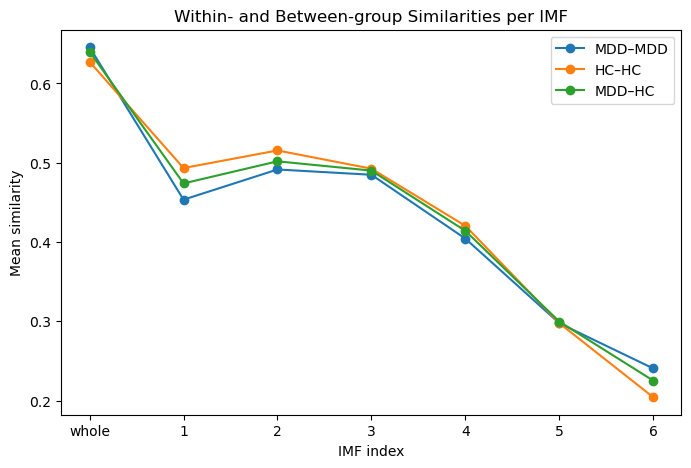

In [4]:
subjects_combined, fcs_by_imf, groups, freqs_by_imf = load_fc_data(RES_DIR)

summary_imf = analyze_similarity_by_imf(fcs_by_imf, groups)
summary_imf["IMF"] = summary_imf["IMF"].astype(str)
plt.figure(figsize=(8,5))
plt.plot(summary_imf["IMF"], summary_imf["MDD–MDD"], 'o-', label='MDD–MDD')
plt.plot(summary_imf["IMF"], summary_imf["HC–HC"], 'o-', label='HC–HC')
plt.plot(summary_imf["IMF"], summary_imf["MDD–HC"], 'o-', label='MDD–HC')
plt.legend(); 
plt.xlabel("IMF index"); 
plt.ylabel("Mean similarity");
plt.title("Within- and Between-group Similarities per IMF");
plt.show()

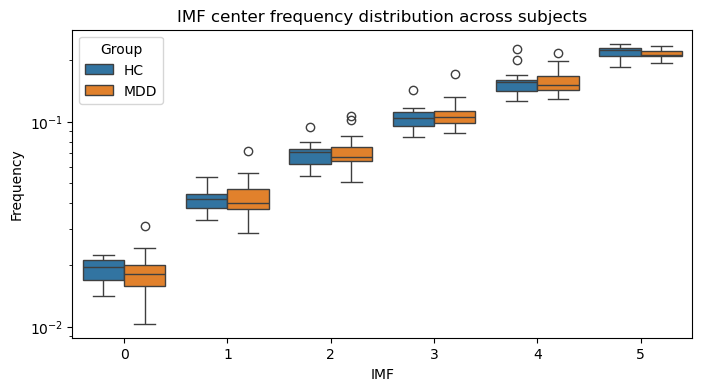

In [5]:
import seaborn as sns

all_freqs = []
all_labels = []
for subj, entry in subjects_combined.items():
    freqs = entry[0]["freqs"]
    group = entry[0]["group"]
    for i, f in enumerate(freqs, start=1):
        all_freqs.append(f)
        all_labels.append((group, i-1))

df = pd.DataFrame(all_labels, columns=["Group", "IMF"])
df["Frequency"] = all_freqs

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="IMF", y="Frequency", hue="Group")
plt.yscale("log")
plt.title("IMF center frequency distribution across subjects")
plt.show()

#### Frequency bands

In [6]:
def bin_fcs_by_freq(subjects_combined, freq_bands):
    binned = {band: defaultdict(list) for band in freq_bands}
    
    for subj, entries in subjects_combined.items():
        e = entries[0]
        # Assign each IMF FC to its corresponding frequency band
        for f, fc in zip(e["freqs"], e["fc_modes"]):
            for band, (fmin, fmax) in freq_bands.items():
                if fmin <= f < fmax:
                    binned[band][subj].append(fc)
                    


    # Average FCs per subject for each band
    binned_mean = {
        band: {s: np.nanmean(fcs, axis=0) for s, fcs in subj_dict.items()}
        for band, subj_dict in binned.items()
    }

    return binned_mean



In [10]:
freq_bands = {
    #"Slow-6": (0.005, 0.01),
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

fcs_by_band = bin_fcs_by_freq(subjects_combined, freq_bands)
fcs_by_band["Whole"] = {s: fcs_by_imf["whole"][s] for s in fcs_by_imf["whole"]}

from collections import OrderedDict

order = ["Whole", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]
fcs_by_band = OrderedDict((k, fcs_by_band[k]) for k in order if k in fcs_by_band)

summary_band = []
for band, fcs in fcs_by_band.items():
    sim, subs = compute_similarity_matrix(fcs)
    MDD_MDD, HC_HC, MDD_HC = group_similarity_means(sim, subs, groups)
    diff, pval = permutation_test_within_vs_between(sim, subs, groups)
    summary_band.append((band, MDD_MDD, HC_HC, MDD_HC, diff, pval))
summary_band = pd.DataFrame(summary_band, columns=["Band", "MDD–MDD", "HC–HC", "MDD–HC", "Δ", "p"])
print(summary_band)

     Band   MDD–MDD     HC–HC    MDD–HC         Δ       p
0   Whole  0.645664  0.627328  0.639983 -0.003487  0.3204
1  Slow-5  0.456609  0.493332  0.476154 -0.000266  0.9514
2  Slow-4  0.527821  0.541860  0.534671  0.000169  0.9556
3  Slow-3  0.460673  0.464514  0.464445 -0.001851  0.5742
4  Slow-2  0.227180  0.180284  0.207369 -0.011568  0.1632


{'Slow-5': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'Slow-4': [1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2], 'Slow-3': [3, 2, 3, 2, 2, 1, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2], 'Slow-2': [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]}


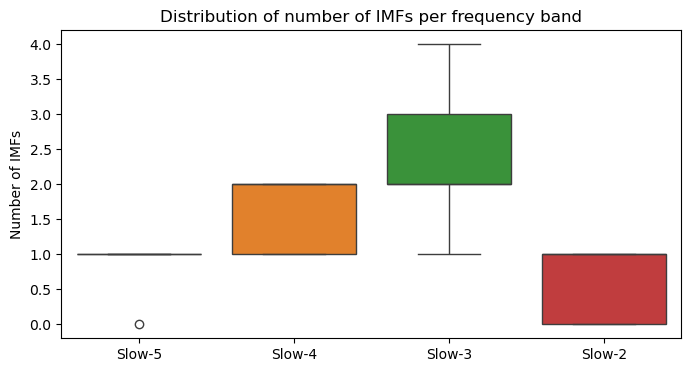

In [11]:
# Count number of IMFs within each frequency band
n_imfs_per_band = {band: [] for band in freq_bands}
for subj, entries in subjects_combined.items():
    e = entries[0]
    imf_counts = {band: 0 for band in freq_bands}
    for f in e["freqs"]:
        for band, (fmin, fmax) in freq_bands.items():
            if fmin <= f < fmax:
                imf_counts[band] += 1
    for band in freq_bands:
        n_imfs_per_band[band].append(imf_counts[band])
        
print(n_imfs_per_band)
# Display distribution of IMF counts per band
plt.figure(figsize=(8,4))
df_counts = pd.DataFrame({band: counts for band, counts in n_imfs_per_band.items()})
sns.boxplot(data=df_counts)
plt.title("Distribution of number of IMFs per frequency band")
plt.ylabel("Number of IMFs")
plt.show() 

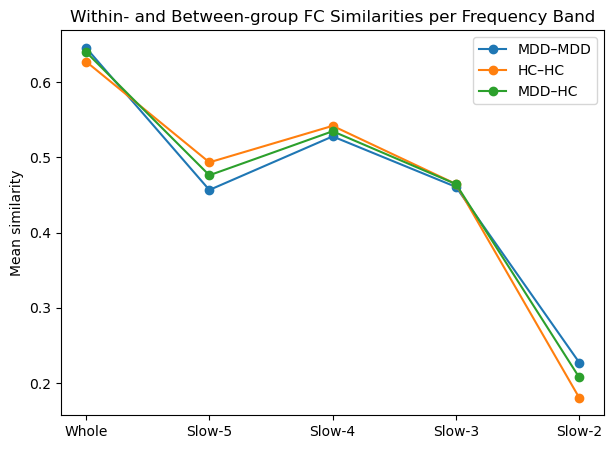

In [12]:
plt.figure(figsize=(7,5))
plt.plot(summary_band["Band"], summary_band["MDD–MDD"], 'o-', label='MDD–MDD')
plt.plot(summary_band["Band"], summary_band["HC–HC"], 'o-', label='HC–HC')
plt.plot(summary_band["Band"], summary_band["MDD–HC"], 'o-', label='MDD–HC')
plt.legend()
plt.ylabel("Mean similarity")
plt.title("Within- and Between-group FC Similarities per Frequency Band")
plt.show()


#### Network aggregation

In [13]:
def aggregate_to_network_fc(fc, roi_to_net, n_networks):
    net_fc = np.zeros((n_networks, n_networks))
    for i in range(n_networks):
        idx_i = np.where(roi_to_net == i)[0]
        for j in range(n_networks):
            idx_j = np.where(roi_to_net == j)[0]
            vals = fc[np.ix_(idx_i, idx_j)]
            net_fc[i, j] = np.nanmean(vals)
    net_fc = (net_fc + net_fc.T) / 2
    #np.fill_diagonal(net_fc, 0)
    return net_fc

def networkpair_permtest(mdd_mats, hc_mats, n_perm=5000):
    n_net = mdd_mats.shape[1]
    diff_mat = np.zeros((n_net, n_net))
    p_mat = np.ones((n_net, n_net))
    d_mat = np.zeros((n_net, n_net))
    g_mat = np.zeros((n_net, n_net))

    for i in range(n_net):
        for j in range(i+1, n_net):
            mdd_vals = mdd_mats[:, i, j]
            hc_vals  = hc_mats[:, i, j]

            # Compute group mean difference
            true_diff = np.nanmean(mdd_vals) - np.nanmean(hc_vals)

            # Compute permutation p-value
            combined = np.concatenate([mdd_vals, hc_vals])
            n_mdd = len(mdd_vals)
            perm_diffs = np.zeros(n_perm)
            for p in range(n_perm):
                perm = np.random.permutation(combined)
                perm_diffs[p] = np.mean(perm[:n_mdd]) - np.mean(perm[n_mdd:])
            p_val = np.mean(np.abs(perm_diffs) >= np.abs(true_diff))

            # Compute Cohen's d
            d_val = cohen_d(mdd_vals, hc_vals)
            g_val = hedges_g(mdd_vals, hc_vals)

            diff_mat[i, j] = diff_mat[j, i] = true_diff
            p_mat[i, j] = p_mat[j, i] = p_val
            d_mat[i, j] = d_mat[j, i] = d_val
            g_mat[i, j] = g_mat[j, i] = g_val

    return diff_mat, p_mat, d_mat, g_mat



In [ ]:
import pandas as pd
import numpy as np

# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

# --- Group by numeric ID and take the first name per network ---
net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)


In [15]:
binned_netfcs = {
    band: {s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
           for s, fc in subj_dict.items()}
    for band, subj_dict in fcs_by_band.items()
}

whole_netfcs = {
    s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for s, fc in fcs_by_imf["whole"].items()
}


#### Visualization

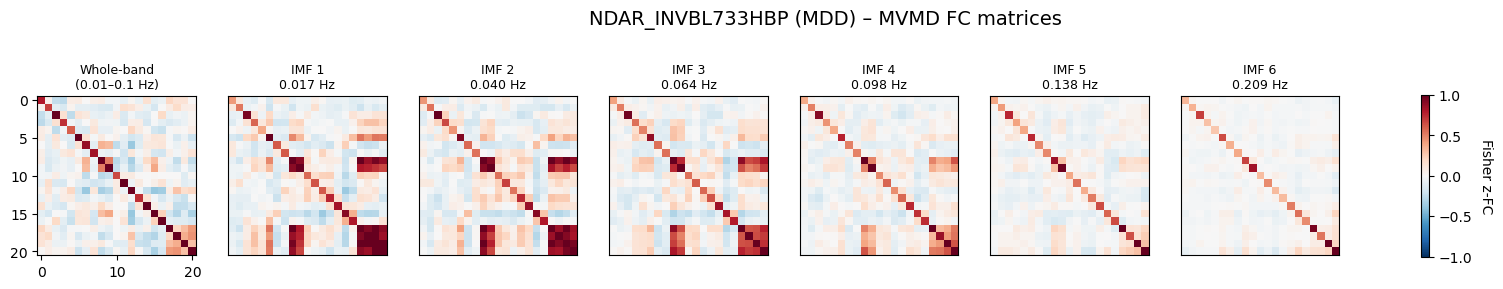

In [16]:
from utils.plot.plot_fc import plot_fc_subject_combined
import pickle, os

mdd_subjects = [s for s, g in groups.items() if g == "MDD"]
hc_subjects  = [s for s, g in groups.items() if g == "HC"]

mdd_subj_id = mdd_subjects[0]

path = os.path.join(RES_DIR, f"{mdd_subj_id}_combined_fc.pkl")
with open(path, "rb") as f:
    subj_data = pickle.load(f)

agg_fc_modes = [
    aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for fc in subj_data["fc_modes"]
]
agg_fc_whole = aggregate_to_network_fc(subj_data["fc_whole"], roi_to_net, n_networks)


subj_data["fc_modes"] = np.stack(agg_fc_modes, axis=0)
subj_data["fc_whole"] = agg_fc_whole


plot_fc_subject_combined(mdd_subj_id, {mdd_subj_id: subj_data}, include_wholeband=True, save=False, method_name="MVMD")

#### Statistical testing

In [17]:
from scipy.stats import pearsonr
import numpy as np
def fc_similarity(fc1, fc2):
    v1, v2 = flatten_fc(fc1), flatten_fc(fc2)
    mask = ~np.isnan(v1) & ~np.isnan(v2)
    if np.sum(mask) < 2:
        return np.nan
    return pearsonr(v1[mask], v2[mask])[0]

def summarize_network_differences(results_band, level_col="Band", top_n=5):
    levels = results_band[level_col].unique()
    for level in levels:
        df_band = results_band[results_band[level_col] == level].copy()
        df_band = df_band.sort_values("p").reset_index(drop=True)
        print(f"\n=== {level_col} {level} ===")
        for _, row in df_band.head(top_n).iterrows():
            print(f"{row['Net1']:>15} – {row['Net2']:<15}  "
                  f"ΔFC = {row['ΔFC']:+.3f}, p = {row['p']:.4f}, "
                  f"p_FDR = {row['p_FDR']:.4f} "
                  f"Cohen's d = {row['Cohen']:.3f}, "
                  f"Hedges' g = {row['Hedges']:.3f}, "
                  f"({'↑' if row['ΔFC'] > 0 else '↓'} in MDD)")

In [18]:
from statsmodels.stats.multitest import fdrcorrection

results_band = []

for band, subj_fcs in binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])

    diff_mat, p_mat, d_mat, g_mat = networkpair_permtest(mdd, hc)
    iu = np.triu_indices(n_networks, 1)
    df = pd.DataFrame({
        "Band": band,
        "Net1": [net_names_21[i] for i in iu[0]],
        "Net2": [net_names_21[j] for j in iu[1]],
        "ΔFC": diff_mat[iu],
        "p": p_mat[iu],
        "Cohen": d_mat[iu],
        "Hedges": g_mat[iu]
    })
    _, df["p_FDR"] = fdrcorrection(df["p"])
    results_band.append(df)

results_band = pd.concat(results_band)

summarize_network_differences(results_band, level_col="Band", top_n=5)


=== Band Whole ===
       DefaultA – LimbicA          ΔFC = -0.065, p = 0.0042, p_FDR = 0.8820 Cohen's d = -0.941, Hedges' g = -0.923, (↓ in MDD)
       DefaultA – SalVentAttnA     ΔFC = +0.039, p = 0.0184, p_FDR = 0.9775 Cohen's d = 0.769, Hedges' g = 0.754, (↑ in MDD)
   SalVentAttnA – MTL              ΔFC = -0.035, p = 0.0206, p_FDR = 0.9775 Cohen's d = -0.735, Hedges' g = -0.721, (↓ in MDD)
       DefaultA – SalVentAttnB     ΔFC = +0.060, p = 0.0244, p_FDR = 0.9775 Cohen's d = 0.712, Hedges' g = 0.698, (↑ in MDD)
       DefaultA – LimbicB          ΔFC = -0.063, p = 0.0310, p_FDR = 0.9775 Cohen's d = -0.711, Hedges' g = -0.698, (↓ in MDD)

=== Band Slow-5 ===
        LimbicA – MTL              ΔFC = -0.195, p = 0.0134, p_FDR = 0.9990 Cohen's d = -0.803, Hedges' g = -0.787, (↓ in MDD)
       DefaultA – LimbicB          ΔFC = -0.095, p = 0.0150, p_FDR = 0.9990 Cohen's d = -0.788, Hedges' g = -0.772, (↓ in MDD)
        LimbicB – MTL              ΔFC = -0.169, p = 0.0182, p_FDR = 0.999

IMF 1: tested 93961 edges.
68.3% of edges violate normality (p < 0.05).


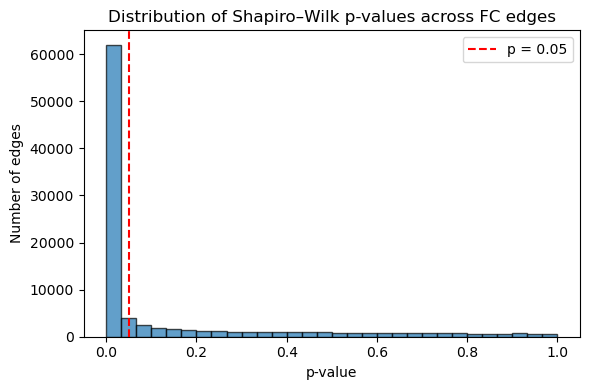

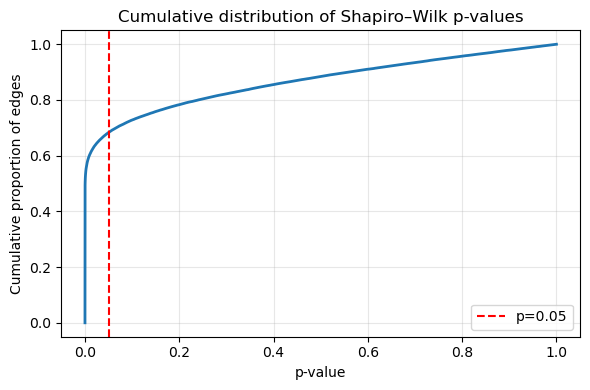

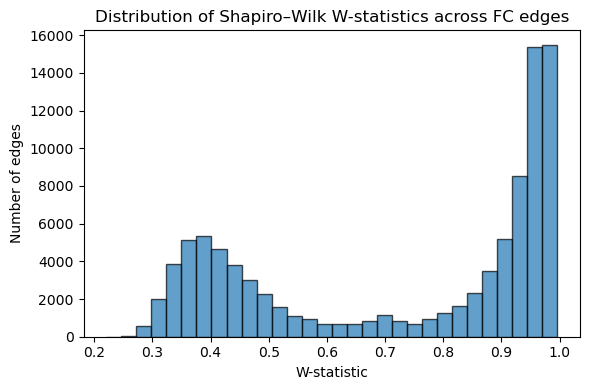

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import pandas as pd
from scipy.stats import shapiro

def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5 * np.log((1 + r) / (1 - r))

def check_fc_normality(fcs_by_imf, groups, imf_idx, network_names=None, min_n=3, return_X=False):
    fcs = fcs_by_imf[imf_idx]
    subs = [s for s in fcs.keys() if s in groups and fcs[s] is not None]

    # agree on a common shape
    shapes = {s: np.asarray(fcs[s]).shape for s in subs}
    if not shapes:
        cols = ["Net1","Net2","n","Shapiro_W","p"]
        empty = pd.DataFrame(columns=cols)
        return (empty, None, network_names) #if return_X else empty

    from collections import Counter
    modal_shape, _ = Counter(shapes.values()).most_common(1)[0]
    subs = [s for s in subs if shapes[s] == modal_shape]
    if not subs:
        cols = ["Net1","Net2","n","Shapiro_W","p"]
        empty = pd.DataFrame(columns=cols)
        return (empty, None, network_names) #if return_X else empty

    n_net = modal_shape[0]
    if network_names is None or len(network_names) != n_net:
        network_names = [f"N{i:02d}" for i in range(n_net)]

    X = np.stack([fisher_z(np.asarray(fcs[s])) for s in subs], axis=0)

    results = []
    for i in range(n_net):
        for j in range(i+1, n_net):
            vals = X[:, i, j]
            vals = vals[~np.isnan(vals)]
            if vals.size < min_n:
                continue
            W, p = shapiro(vals)
            results.append({
                "Net1": network_names[i],
                "Net2": network_names[j],
                "n": int(vals.size),
                "Shapiro_W": float(W),
                "p": float(p),
            })

    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values("p").reset_index(drop=True)

    print(f"IMF {imf_idx}: tested {len(df)} edges.")
    return df, X, network_names #if return_X else df

df_norm, X, network_names = check_fc_normality(fcs_by_imf, groups, imf_idx=1, network_names=net_names_21)

non_normal = (df_norm["p"] < 0.05).mean()
print(f"{non_normal*100:.1f}% of edges violate normality (p < 0.05).")

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_norm["p"], bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0.05, color='r', linestyle='--', label='p = 0.05')
plt.title("Distribution of Shapiro–Wilk p-values across FC edges")
plt.xlabel("p-value")
plt.ylabel("Number of edges")
plt.legend()
plt.tight_layout()
plt.show()


import numpy as np

sorted_p = np.sort(df_norm["p"])
cdf = np.arange(1, len(sorted_p)+1) / len(sorted_p)

plt.figure(figsize=(6,4))
plt.plot(sorted_p, cdf, lw=2)
plt.axvline(0.05, color='r', linestyle='--', label='p=0.05')
plt.title("Cumulative distribution of Shapiro–Wilk p-values")
plt.xlabel("p-value")
plt.ylabel("Cumulative proportion of edges")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_norm["Shapiro_W"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Shapiro–Wilk W-statistics across FC edges")
plt.xlabel("W-statistic")
plt.ylabel("Number of edges")
plt.tight_layout()
plt.show()

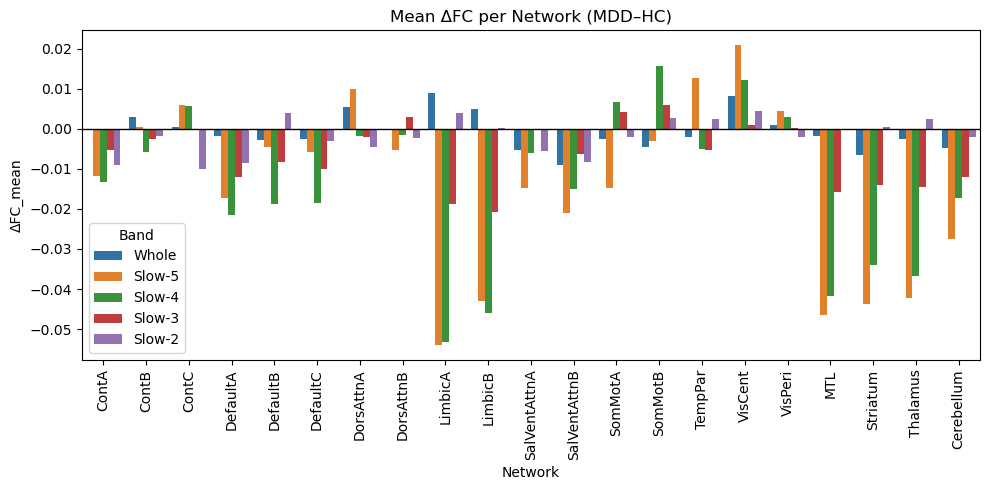

In [19]:
import pandas as pd
import numpy as np

summary = []

for band, subj_fcs in binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])

    diff_mat = np.nanmean(mdd, axis=0) - np.nanmean(hc, axis=0)
    
    # mean ΔFC of each network with all others
    mean_dfc = np.nanmean(diff_mat, axis=1)
    
    df_band = pd.DataFrame({
        "Network": net_names_21,
        "ΔFC_mean": mean_dfc,
        "Band": band
    })
    summary.append(df_band)

summary_df = pd.concat(summary)

# plot per band
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Network", y="ΔFC_mean", hue="Band")
plt.axhline(0, color='k', lw=1)
plt.xticks(rotation=90)
plt.title("Mean ΔFC per Network (MDD–HC)")
plt.tight_layout()
plt.show()

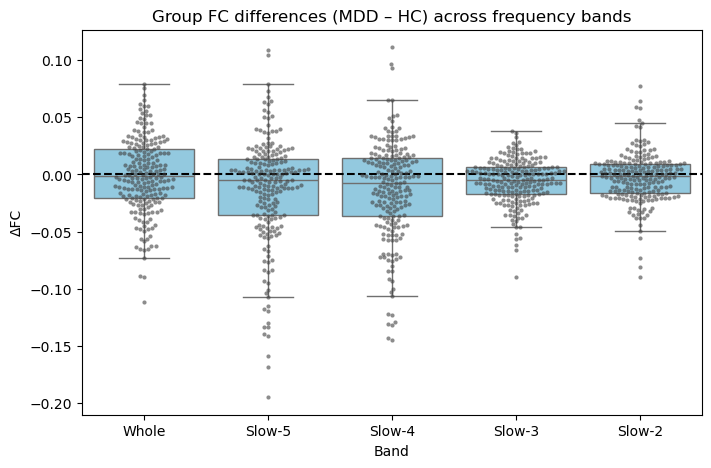

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=results_band, x="Band", y="ΔFC", color="skyblue", showfliers=False)
sns.swarmplot(data=results_band, x="Band", y="ΔFC", color=".25", size=3, alpha=0.6)

plt.axhline(0, color='k', linestyle='--')
plt.title("Group FC differences (MDD – HC) across frequency bands")
plt.show()